In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cuda


In [3]:
# Learning rate for the optimizer
LEARNING_RATE = 2e-4

# Number of samples per batch to load
BATCH_SIZE = 128

"""
Spatial size of training images. All images will be resized to this
size using a transformer.
"""
IMAGE_SIZE = 64

"""
Number of channels in the training images. For color images this is 3.
"""
CHANNELS_IMG = 3  

"""
Size of z latent vector (i.e. size of generator input).
"""
NOISE_DIM = 100

# Number of epochs to train for
NUM_EPOCHS = 50

"""
Size of feature maps in discriminator. This is the depth of the output volumes 
(i.e. the number of output channels) in the convolutional layers of the discriminator.
"""
FEATURES_DISC = 64 

"""
Size of feature maps in generator. This is the depth of the output volumes 
(i.e. the number of output channels) in the convolutional layers of the generator.
"""
FEATURES_GEN = 64 

"""
Beta hyperparameter for Adam optimizers. This is the exponential decay rate 
for the first moment estimates in the Adam optimizer.
"""
beta = 0.5

# Number of classes in the dataset
NUM_CLASSES = 10

# Size of the embedding vector
EMBED_SIZE = 100

# Number of iterations for the critic (discriminator)
criticItr = 5

In [4]:
# Importing the CIFAR10 dataset from torchvision.datasets
dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data",  # The root directory where the dataset will be stored
    download=True,  # If True, downloads the dataset from the internet and puts it in root directory
    transform=transforms.Compose([  # A function/transform that takes in an PIL image and returns a transformed version
        transforms.Resize(64),  # Resizes the image to the specified size
        transforms.ToTensor(),  # Converts the image to a PyTorch Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalizes the image with the specified mean and standard deviation
    ])
)

# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset
dataloader = torch.utils.data.DataLoader(
    dataset,  # The dataset to load
    batch_size=BATCH_SIZE,  # How many samples per batch to load
    shuffle=True,  # If True, shuffles the dataset at every epoch
    num_workers=2  # The number of subprocesses to use for data loading
)

Files already downloaded and verified


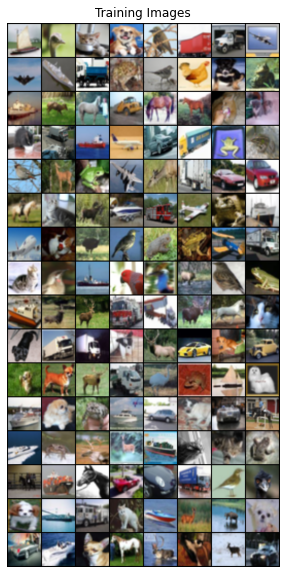

In [5]:
# Get the first batch of the training images
real_batch = next(iter(dataloader))

# Create a new figure with a specified size
plt.figure(figsize=(10,10))

# Hide the axes of the plot
plt.axis("off")

# Set the title of the plot
plt.title("Training Images")

# Display the images in the batch
# The images are moved to the device, a grid is made from the batch, the grid is normalized,
# moved back to the CPU, and the color channels are rearranged for displaying
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator(nn.Module):
    """
    Generator Class for ACGAN. 
    The Generator is responsible for generating images from noise.
    """
    def __init__(self, num_classes, img_size, embed_size, channels_noise, channels_img, features_g):
        """
        Constructor for the Generator class
        """
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            # Gnet(in_channels, out_channels, kernel_size, stride, padding)
            nn.ConvTranspose2d(NOISE_DIM+embed_size, features_g * 16, 4, 1, 0, bias=False),  # Transposed convolution layer
            
            # Transposed convolution layers to upscale the image
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            
            # Final transposed convolution layer to get the desired image size and channels
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            
            # Tanh activation function to get pixel values between -1 and 1
            nn.Tanh(),
        )
        
        # Embedding layer for the class labels
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Function to create a sequence of a transposed convolution layer, a batch normalization layer, and a ReLU activation layer
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),  # Batch normalization layer
            nn.ReLU(),  # ReLU activation layer
        )

    def forward(self, x, labels):
        """
        Forward pass of the generator
        """
        # Embed the labels and add a dimension to match the noise vector
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        
        # Concatenate the noise vector and the embedded labels
        x = torch.cat([x, embedding], dim=1)
        
        # Pass the concatenated vector through the network
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    """
    Discriminator Class for ACGAN. 
    The Discriminator is responsible for distinguishing real images from fake ones and classifying the real images.
    """
    def __init__(self, num_classes, img_size, channels_img, features_d):    
        """
        Constructor for the Discriminator class
        """
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),  # Convolutional layer
            nn.LeakyReLU(0.2),  # LeakyReLU activation function
            
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
        )
        
        # Layer to output the validity of the image (real or fake)
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),  # Convolutional layer
            nn.Sigmoid()  # Sigmoid activation function
        )
        
        # Layer to output the class label of the image
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False),  # Convolutional layer
            nn.LogSoftmax(dim = 1)  # LogSoftmax activation function
        )
        
        # Embedding layer for the class labels
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Function to create a sequence of a convolutional layer and a LeakyReLU activation layer
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),  # Convolutional layer
            nn.LeakyReLU(0.2),  # LeakyReLU activation function
        )

    def forward(self, x):
        """
        Forward pass of the discriminator
        """
        x = self.disc(x)  # Pass the image through the discriminator
        valid = self.validity_layer(x).view(-1)  # Get the validity of the image
        label = self.labels(x).view(-1,11)  # Get the class label of the image
        return valid, label

In [8]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [9]:
# Create an instance of the Generator class and move it to the device
gen = Generator(NUM_CLASSES, IMAGE_SIZE, EMBED_SIZE, NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

# Create an instance of the Discriminator class and move it to the device
disc = Discriminator(NUM_CLASSES, IMAGE_SIZE, CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize the weights of the generator
initialize_weights(gen)

# Initialize the weights of the discriminator
initialize_weights(disc)

In [10]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

In [11]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [12]:
# Create an Adam optimizer for the discriminator with the specified learning rate and betas
disOptim = optim.Adam(disc.parameters(), LEARNING_RATE, betas = (0.5,0.999))

# Create an Adam optimizer for the generator with the specified learning rate and betas
genOptim = optim.Adam(gen.parameters(), LEARNING_RATE, betas = (0.5,0.999))

# Create a Binary Cross Entropy Loss function
criterion = nn.BCELoss()

# Variables to track training progress
counterList = []  # List to store the number of iterations
counter = 0  # Counter for the number of iterations
genLossList = []  # List to store the generator loss at each iteration
disLossList = []  # List to store the discriminator loss at each iteration
img_list = []  # List to store the generated images at each iteration

In [13]:
# List to store the loss of the Generator
GenLoss = []

# List to store the loss of the Discriminator
DiscLoss = []

# List to store the generated images
img_list = []

# Counter for the number of iterations
iters = 0

# List to store the Fréchet Inception Distance (FID) score
FID_list = []

print("!!Training Started!!")

# Record the start time of the training
time_start = time.time() 

# Loop over the dataset multiple times
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1

    # Loop over all batches
    for batch_idx, (realImg,labels) in enumerate(dataloader):
        # Move the real images and labels to the device
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]

        # Create a tensor of ones with the same size as the batch and move it to the device
        # This tensor represents the labels for the fake images (all fake images are labeled as class 10)
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)

        # Zero the gradients of the discriminator
        disc.zero_grad()

        ### Train Discriminator with Real image####
        # Create a tensor of ones with the same size as the batch and move it to the device
        # This tensor represents the real labels (all real images are labeled as 1)
        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)

        # Pass the real images through the discriminator
        disc_real, disc_label = disc(real)

        # Compute the loss between the discriminator's predictions and the real labels
        loss_disc_realVal = criterion(disc_real, r_label)

        # Compute the loss between the discriminator's predicted labels and the real labels
        discRealLabelLoss = F.nll_loss(disc_label, labels) 

        # Compute the total loss for the real images
        realLoss_disc = loss_disc_realVal + discRealLabelLoss

        # Backpropagate the gradients
        realLoss_disc.backward()

        ### Train Discriminator with Fake image####
        # Generate a batch of random labels
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)

        # Generate a batch of random noise
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)

        # Generate a batch of fake images
        fake = gen(noise,sampleLabel)

        # Pass the fake images through the discriminator
        disc_fake, disc_fLabel = disc(fake.detach())

        # Fill the real labels tensor with zeros
        # This tensor now represents the fake labels (all fake images are labeled as 0)
        r_label.fill_(0.0)

        # Compute the loss between the discriminator's predictions and the fake labels
        loss_disc_fakelVal = criterion(disc_fake, r_label)

        # Compute the loss between the discriminator's predicted labels and the fake labels
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 

        # Compute the total loss for the fake images
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss

        # Backpropagate the gradients
        fakeLoss_disc.backward()

        # Compute the average discriminator loss
        loss_disc = (realLoss_disc+fakeLoss_disc)/2

        # Update the weights of the discriminator
        disOptim.step()

        ### Train Generator ###
        # Zero the gradients of the generator
        gen.zero_grad()

        # Generate a batch of random noise
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)

        # Generate a batch of random labels
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)

        # Fill the real labels tensor with ones
        # This tensor now represents the real labels (the generator wants to fool the discriminator into thinking that the fake images are real)
        r_label.fill_(1.0)

        # Generate a batch of fake images
        fake = gen(noise, sampleLabel)

        # Pass the fake images through the discriminator
        genOutput, genOutputLabel = disc(fake)

        # Compute the loss between the discriminator's predictions and the real labels
        loss_gen_r = criterion(genOutput, r_label)

        # Compute the loss between the discriminator's predicted labels and the real labels
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)

        # Compute the total generator loss
        loss_gen = loss_gen_r + genLabelLoss

        # Backpropagate the gradients
        loss_gen.backward()

        # Update the weights of the generator
        genOptim.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}"
            )

        # Save the losses
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise, sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Record the end time of the training
time_end = time.time()

# Print the elapsed time
print('elapsed time：%.2f s.'%(time_end-time_start))

!!Training Started!!
Epoch [1/50] Batch 0/391                   Loss Discriminator: 3.092, loss Generator: 3.154
Epoch [1/50] Batch 100/391                   Loss Discriminator: 1.062, loss Generator: 18.432
Epoch [1/50] Batch 200/391                   Loss Discriminator: 1.570, loss Generator: 5.742
Epoch [1/50] Batch 300/391                   Loss Discriminator: 1.877, loss Generator: 3.408
Epoch [2/50] Batch 0/391                   Loss Discriminator: 1.736, loss Generator: 3.751
Epoch [2/50] Batch 100/391                   Loss Discriminator: 1.856, loss Generator: 3.195
Epoch [2/50] Batch 200/391                   Loss Discriminator: 2.099, loss Generator: 2.744
Epoch [2/50] Batch 300/391                   Loss Discriminator: 2.034, loss Generator: 3.109
Epoch [3/50] Batch 0/391                   Loss Discriminator: 1.897, loss Generator: 2.768
Epoch [3/50] Batch 100/391                   Loss Discriminator: 1.934, loss Generator: 2.988
Epoch [3/50] Batch 200/391                  

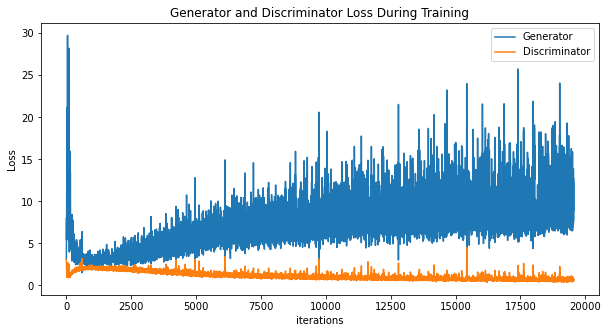

In [16]:
# Set the size of the figure
plt.figure(figsize=(10,5))

# Set the title of the figure
plt.title("Generator and Discriminator Loss During Training")

# Plot the generator loss
plt.plot(GenLoss,label="Generator")

# Plot the discriminator loss
plt.plot(DiscLoss,label="Discriminator")

# Set the label of the x-axis
plt.xlabel("iterations")

# Set the label of the y-axis
plt.ylabel("Loss")

# Add a legend to the figure
plt.legend()

# Display the figure
plt.show()

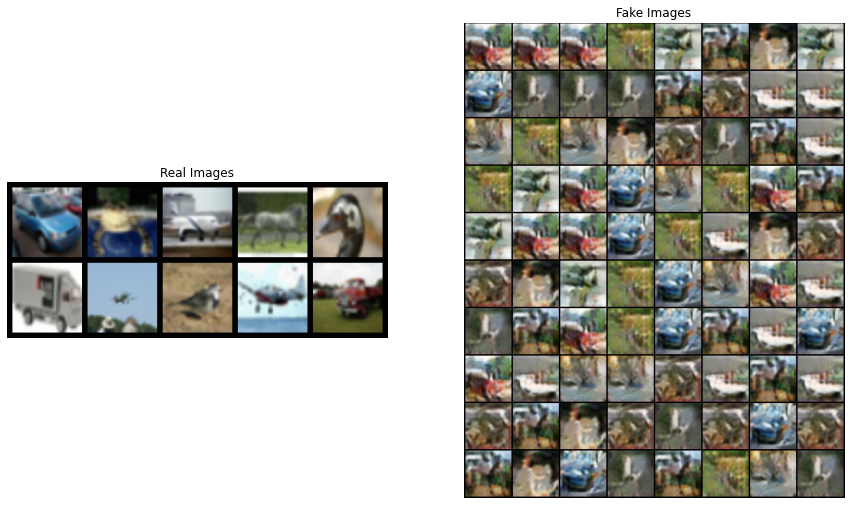

In [17]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()